# EE 511 Assignment 2 - PartII
University of Washington<br>
Code by John Ragland and Doruk Arisoy<br>
Winter 2021

In [87]:
import tools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## \[Step 3\] Load training, validation and testing data

In [95]:
train, valid, test = tools.load_data()

## \[Step 4\] One variable least squares linear regression 

In [96]:
area_label = 'Gr Liv Area'
price_label = 'SalePrice'

area_train = np.array(train[area_label])
area_valid = np.array(valid[area_label])
area_test = np.array(test[area_label])
price_train = np.array(train[price_label])
price_valid = np.array(valid[price_label])
price_test = np.array(test[price_label])

In [97]:
weights, shift = tools.calculate_OLS(area_train.T, price_train.T)

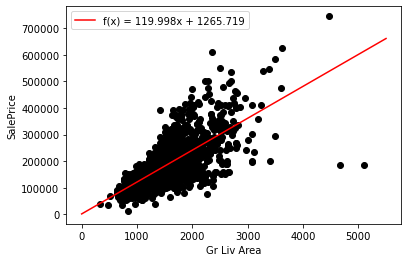

In [98]:
x = np.linspace(0, 5500, 100)
y = weights * x + shift

plt.xlabel(area_label)
plt.ylabel(price_label)
plt.plot(area_train, price_train, 'o', color='black')
plt.plot(x, y, '-r', label="f(x) = %.3fx + %.3f" % (weights, shift))
plt.legend()

In [99]:
price_predicted = tools.predict(np.array(area_valid), weights, shift)
print("RMSE = $%.2f" % (tools.rmse(price_valid, price_predicted)))

RMSE = $56331.07


## \[Step 5\] Adding more features to the simple model

In [100]:
train_without_price = train.drop(price_label, 1).to_numpy()
weights, shift = tools.calculate_OLS(train_without_price, price_train.T)

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
valid_without_price = valid.drop(price_label, 1).to_numpy()
price_predicted = tools.predict(valid_without_price, weights, shift)
print("RMSE = $%.2f" % (tools.rmse(price_valid, price_predicted)))